<a href="https://colab.research.google.com/github/HarshitManik/Glucos_sparameter_frequencey_prediction/blob/main/Glucose_monitoring_trial_2_hypertuningipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
import pandas as pd

# Upload the file
uploaded = files.upload()

# Read the CSV file into a DataFrame
for filename in uploaded.keys():
    df = pd.read_csv(filename)
    print(f"Uploaded file: {filename}")
    print(df.head())  # Display the first few rows of the dataframe


Saving BGL_DATASET_2.csv to BGL_DATASET_2.csv
Uploaded file: BGL_DATASET_2.csv
    FREQ        S11  bgl
0  0.000 -18.901456  400
1  0.015 -18.859446  400
2  0.030 -18.735411  400
3  0.045 -18.535068  400
4  0.060 -18.267139  400


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


376/376 - 4s - 11ms/step - loss: 182.2705 - mae: 182.2705 - val_loss: 114.8760 - val_mae: 114.8760 - learning_rate: 0.0010
Epoch 2/100
376/376 - 2s - 6ms/step - loss: 98.6406 - mae: 98.6406 - val_loss: 92.6907 - val_mae: 92.6907 - learning_rate: 0.0010
Epoch 3/100
376/376 - 1s - 2ms/step - loss: 91.7422 - mae: 91.7422 - val_loss: 91.8005 - val_mae: 91.8005 - learning_rate: 0.0010
Epoch 4/100
376/376 - 1s - 2ms/step - loss: 90.8641 - mae: 90.8641 - val_loss: 90.3785 - val_mae: 90.3785 - learning_rate: 0.0010
Epoch 5/100
376/376 - 1s - 2ms/step - loss: 90.1172 - mae: 90.1172 - val_loss: 90.1734 - val_mae: 90.1734 - learning_rate: 0.0010
Epoch 6/100
376/376 - 1s - 3ms/step - loss: 89.9407 - mae: 89.9407 - val_loss: 89.8482 - val_mae: 89.8482 - learning_rate: 0.0010
Epoch 7/100
376/376 - 1s - 2ms/step - loss: 89.4609 - mae: 89.4609 - val_loss: 89.8278 - val_mae: 89.8278 - learning_rate: 0.0010
Epoch 8/100
376/376 - 1s - 3ms/step - loss: 89.4709 - mae: 89.4709 - val_loss: 89.9019 - val_mae:

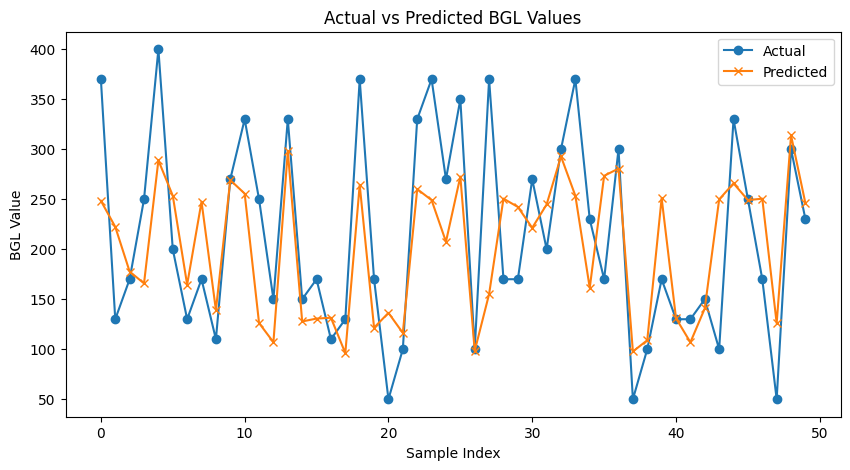

In [2]:
# Install TensorFlow if not already installed
!pip install tensorflow pandas scikit-learn matplotlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Load the dataset
data = pd.read_csv('/content/BGL_DATASET_2.csv')  # Ensure the file is uploaded to Colab

# Extract features and target
X = data[['FREQ', 'S11']].values
y = data['bgl'].values

# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Reshape for LSTM (samples, timesteps, features)
X = X.reshape((X.shape[0], 1, X.shape[1]))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build an optimized LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)  # Regression output
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mae', metrics=['mae'])

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, verbose=1)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100, batch_size=32,
    validation_data=(X_test, y_test),
    verbose=2, callbacks=[lr_scheduler]
)

# Evaluate the model
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f'Test MAE: {test_mae}')

# Predict on test data
y_pred = model.predict(X_test)

# Plot actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(y_test[:50], label='Actual', marker='o')
plt.plot(y_pred[:50], label='Predicted', marker='x')
plt.legend()
plt.title('Actual vs Predicted BGL Values')
plt.xlabel('Sample Index')
plt.ylabel('BGL Value')
plt.show()


In [5]:
!pip install keras-tuner



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.2 MB/s eta 0:00:00


In [6]:
import numpy as np
import pandas as pd
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load dataset
data = pd.read_csv('/content/BGL_DATASET_2.csv')

# Extract features (S11 and frequency) and target (bgl)
X = data[['FREQ', 'S11']].values
y = data['bgl'].values

# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Reshape the data for LSTM input (samples, timesteps, features)
X = X.reshape((X.shape[0], 1, X.shape[1]))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Function to build the model with hyperparameters
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=16),
                   return_sequences=False,
                   input_shape=(X_train.shape[1], X_train.shape[2])))

    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(Dense(1))  # Regression output layer

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.0005, 0.0001])),
                  loss='mse',
                  metrics=['mae'])

    return model

# Use Keras Tuner for Hyperparameter Tuning
tuner = kt.RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=10,  # Number of different hyperparameter combinations to test
    executions_per_trial=2,  # Average results over multiple runs
    directory='hyper_tuning',
    project_name='bgl_lstm_tuning'
)

# Search for best hyperparameters
tuner.search(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=2)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: Units={best_hps.get('units')}, Dropout={best_hps.get('dropout')}, LR={best_hps.get('learning_rate')}")

# Build the best model using optimized hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Use early stopping to prevent overfitting
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = best_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test),
                         callbacks=[early_stop], verbose=2)

# Evaluate on test data
loss, mae = best_model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {loss:.4f}, Test MAE: {mae:.4f}')

# Predict on test data
y_pred = best_model.predict(X_test)

# Compute percentage accuracy
mape = np.mean(np.abs((y_test - y_pred.flatten()) / y_test)) * 100
accuracy = 100 - mape
print(f'Model Accuracy: {accuracy:.2f}%')


Trial 9 Complete [00h 01m 08s]
val_mae: 182.63954162597656

Best val_mae So Far: 91.5813980102539
Total elapsed time: 00h 10m 41s

Search: Running Trial #10

Value             |Best Value So Far |Hyperparameter
96                |128               |units
0.2               |0.4               |dropout
0.0005            |0.001             |learning_rate

Epoch 1/30
376/376 - 2s - 7ms/step - loss: 62195.6836 - mae: 226.4662 - val_loss: 60565.8164 - val_mae: 222.3358
Epoch 2/30
376/376 - 2s - 5ms/step - loss: 58630.1250 - mae: 218.4107 - val_loss: 55484.1250 - val_mae: 210.5652
Epoch 3/30
376/376 - 1s - 2ms/step - loss: 52906.1992 - mae: 204.8831 - val_loss: 49636.5859 - val_mae: 196.1215
Epoch 4/30
376/376 - 1s - 3ms/step - loss: 46996.5977 - mae: 189.8715 - val_loss: 43844.9219 - val_mae: 180.9572
Epoch 5/30
376/376 - 1s - 3ms/step - loss: 41131.4375 - mae: 174.6933 - val_loss: 38140.4102 - val_mae: 165.9080
Epoch 6/30
376/376 - 1s - 3ms/step - loss: 35533.5625 - mae: 159.3878 - val_loss:

KeyboardInterrupt: 